# Bird Flight Analysis


**Install and Imports**

In [1]:
%matplotlib inline

from IPython.display import Image
from pathlib import Path
import logging
import hdbscan
import ipywidgets
import numpy as np
from IPython.core.display_functions import display
from IPython.display import Video
from birdwatchpy.database.flight_data import get_flights_sample
from birdwatchpy.database.flight_data import get_flights_sample_count, create_flight_filter_query_document
from ipywidgets import Layout, widgets
from matplotlib.pyplot import figure
#from birdwatchpy.bird_flight_analysis.trajs_plot import plot_2D
from yupi.graphics import plot_angles_hist
from yupi.graphics import plot_velocity_hist
from yupi.stats import speed_ensemble
from yupi.stats import turning_angles_ensemble
from matplotlib.pyplot import figure
from scipy.fft import fft, fftfreq

/home/jo/coding_projects/fids_bird_detection_and_tracking/notebooks/config.ini
/home/jo/coding_projects/fids_bird_detection_and_tracking/config.ini
Using following config file: /home/jo/coding_projects/fids_bird_detection_and_tracking/notebooks/config.ini
mongodb+srv://cluster0.0sedu.mongodb.net/myFirstDatabase
jo_pw
yaAGMsMUrgwvgp8Z
MongoClient(host=['cluster0-shard-00-00.0sedu.mongodb.net:27017', 'cluster0-shard-00-01.0sedu.mongodb.net:27017', 'cluster0-shard-00-02.0sedu.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-byvvfx-shard-0', tls=True, retrywrites=True, server_api=<pymongo.server_api.ServerApi object at 0x7fce6a1cb100>)


In [2]:
import itertools
import logging
import matplotlib.pyplot as plt
from typing import List, Union
from yupi import Trajectory
from yupi.graphics._style import YUPI_COLORS, LINE

def plot_2D(trajs: Union[List[Trajectory], Trajectory], line_style: str = LINE,
            title: str = None, legend: bool = True, alpha=0.5, show: bool = True,
            connected: bool = False, units: str = 'pixels', color = None, **kwargs):
    """
    Plot all the points of trajectories from ``trajs`` in a 2D plane.

    Parameters
    ----------
    trajs : Union[List[Trajectory], Trajectory]
        Input trajectories.
    line_style : str
        Type of the trajectory line to plot. It uses the matplotlib,
        notation, by default '-'.
    title : str, optional
        Title of the plot, by default None.
    legend : bool, optional
        If True, legend is shown. By default True.
    alpha: float
        Opacity value
    show : bool, optional
        If True, the plot is shown. By default True.
    connected : bool
        If True, all the trajectory points of same index will be,
        connected.

        If the trajectories do not have same length then the points
        will be connected until the shortest trajectory last index.
    color : str or tuple or list
        Defines the color of the trajectories, by default None.

        If color is of type ``str`` or ``tuple`` (rgb) then the color
        is applied to all trajectories. If color is of type ``list``
        then the trajectories take the color according to the index.

        If there are less colors than trajectories then the remaining
        trajectories are colored automatically (not with the same
        color).
    """

    if isinstance(trajs, Trajectory):
        trajs = [trajs]

    units = '' if units is None else f' [{units}]'

    cycle = itertools.cycle(YUPI_COLORS)
    colors = [cycle.__next__() for _ in trajs]

    if color is not None:
        if isinstance(color, (str, tuple)):
            kwargs['color'] = color
        elif isinstance(color, list):
            colors = color

    if connected:
        lengths = list(map(len, trajs))
        min_len = min(lengths)
        max_len = max(lengths)
        if min_len != max_len:
            logging.warning('Not all the trajectories have the same length.')
        for i in range(min_len):
            traj_points = [t[i] for t in trajs]
            traj_points.append(traj_points[0])
            for tp1, tp2 in zip(traj_points[:-1], traj_points[1:]):
                xs = [tp1.r[0], tp2.r[0]]
                ys = [tp1.r[1], tp2.r[1]]
                plt.plot(xs, ys, color=(0.2, 0.2, 0.2), linewidth=0.5)

    for i, t in enumerate(trajs):

        if t.dim != 2:
            logging.warning(f'Using plot_2D with a trajectory of {t.dim} '
                            f' dimensions. Trajectory No. {i} with id'
                            f' {t.traj_id})')

        # Plotting
        x, y = t.r.x, t.r.y
        if colors is not None:
            if i < len(colors):
                kwargs['color'] = colors[i]
            else:
                kwargs.pop('color')
        traj_plot = plt.plot(x, y, line_style, **kwargs)
        color = traj_plot[-1].get_color()
        plt.plot(x[0], y[0], 'o', mfc='white', zorder=2,
                 label=f'{t.traj_id} initial position', color=color)
        plt.plot(x[-1], y[-1], 'o', mfc='white', zorder=2, color=color)
        plt.plot(x[-1], y[-1], 'o', alpha=.5,
                 label=f'{t.traj_id} final position', color=color)

        if legend:
            plt.legend()

        plt.title(title)
        plt.tick_params(direction='in')
        plt.axis('equal')
        plt.grid(True)
        plt.xlim(0,3860)
        plt.ylim(0,2160)
        plt.xlabel(units)
        plt.ylabel(units)

    if show:
        plt.show()


## Sample Analysis

### 1 Filter Settings

In [3]:


from birdwatchpy.bird_flight_analysis.BirdFlightData import BirdFlightData

filter_dict = {
    'min_positions_count': {'value':15, 'min':0 , 'max':120, 'step':1,},
    'max_positions_count': {'value':1800, 'min':120 , 'max':1800, 'step':1,},
    'min_length': {'value':2160, 'min':200, 'max':30000, 'step':1,},
    'max_length': {'value':12000, 'min':200 , 'max':30000, 'step':1,},
    'min_avg_speed': {'value':6, 'min':0 , 'max':500, 'step':0.002,},
    'max_avg_speed': {'value':60, 'min':0 , 'max':500, 'step':0.002,},
    'min_wing_flap_frequency': {'value':0, 'min':0 , 'max':10, 'step':1,},
    'max_wing_flap_frequency': {'value':6, 'min':0 , 'max':15, 'step':1,},
    'min_avg_size': {'value':4, 'min':2 , 'max':100000, 'step':1,},
    'max_avg_size': {'value':100000, 'min':4 , 'max':200000, 'step':1,},
    'max_speed_deviation': {'value':500, 'min':0.1 , 'max':1000, 'step':1,}
}

for filter_name, filter_config in filter_dict.items():
    filter_dict[filter_name]["slider_widget"] =  widgets.IntSlider(filter_config['value'],filter_config['min'],filter_config['max'], filter_config['step'], description=filter_name,layout=Layout(width='auto'),style={'description_width': 'initial'}
)

def show_filter_result_preview(kwargs):
    query_document = create_flight_filter_query_document(**kwargs)
    print(query_document)
    filtered_birds_count = get_flights_sample_count(query_document)

    print(f"Sample Preview: {filtered_birds_count} (Flights)")

def on_slider_interaction(**args):
    show_filter_result_preview(args)
    for filter_name, value in args.items():
        filter_dict[filter_name]["value"] = value


output_sample_preview_MFA = widgets.interactive_output(on_slider_interaction, {filter_name:filter_config["slider_widget"] for filter_name,filter_config in filter_dict.items()})
output_sample_preview_MFA.layout = {"border": "1px solid red"}
output_current_sample_MFA = widgets.Output(layout={'border': '1px solid black'})

flights_sample = []


def update_output_current_sample_MFA():
    output_current_sample_MFA.clear_output()
    with output_current_sample_MFA:
        plot_2D([flight.y_traj for flight in flights_sample], title= "All Flights in filtered Sample", legend=False)


def fetch_new_sample_MFA(value):
    global flights_sample
    query_document =create_flight_filter_query_document(
                                    **{filter_name:filter_config["slider_widget"].value for filter_name,filter_config in filter_dict.items()}
                                )
    flights_sample = [BirdFlightData.load_from_dict(flight_dict) for flight_dict in  get_flights_sample(query_document)]

    update_output_current_sample_MFA()

button_layout = Layout(width='auto',height='80px')

button_new_sample_MFA = ipywidgets.Button(description="New Sample from Filters", layout=button_layout,
                                       button_style="primary")
display(
    ipywidgets.VBox([filter_config["slider_widget"] for filter_config in filter_dict.values()] + [output_sample_preview_MFA]),
    ipywidgets.HBox([button_new_sample_MFA]), )

button_new_sample_MFA.on_click(fetch_new_sample_MFA)

display(output_current_sample_MFA)

fetch_new_sample_MFA("")


Output(layout=Layout(border='1px solid black'))

### 3 Analysis

#### Percentiles

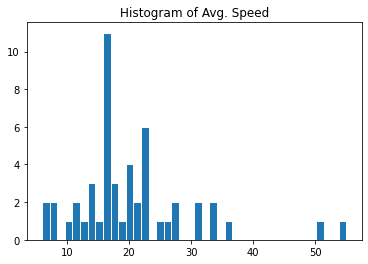

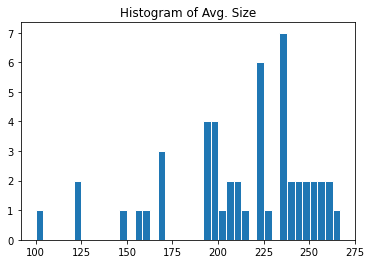

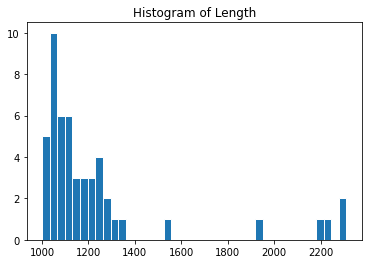

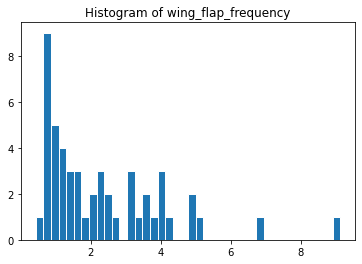

+---------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-------------+-------------+--------+-------------+------------+-------------+-------------+-------------+-------------+
|     Percentiles     |      0      |      5      |      10     |      15     |      20     |      25     |      30     |      35     |     40     |      45     |      50     |      55     |      60     |      65     |   70   |      75     |     80     |      85     |      90     |      95     |     100     |
+---------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-------------+-------------+--------+-------------+------------+-------------+-------------+-------------+-------------+
|      Avg. Speed     |     6.0     |     8.0     |     10.9    |  

In [4]:


from birdwatchpy.database.percentiles import get_percentiles, percentiles
from prettytable import PrettyTable
import numpy as np

percentiles_data_dict = get_percentiles()

for key, values in percentiles_data_dict.items():
    plt.hist(values['data'], bins=40,  edgecolor="white")
    plt.title(f"Histogram of {key}")
    plt.show()

# Table
percentile_table = PrettyTable()
percentile_table.field_names = ["Percentiles"] + percentiles
for key, values in percentiles_data_dict.items():
    percentile_table.add_row([key] + list(values['percentile_res'].values()))
print(percentile_table)

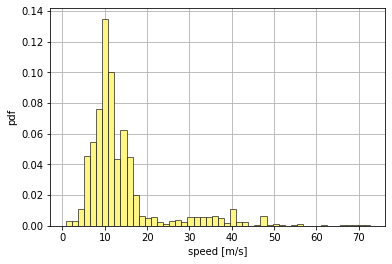

In [5]:
if len(flights_sample) > 0:
    v = speed_ensemble(list(map(lambda flight: flight.y_traj, flights_sample)), step=1)
    plot_velocity_hist(v, bins=50)

#### **Histogram of Turning Angles**

/home/jo/.var/app/com.jetbrains.PyCharm-Professional/data/virtualenvs/fids_bird_detection_and_tracking-jrQ4Gl_l/lib/python3.9/site-packages/yupi/graphics/_stats_plots.py:138: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection="polar")


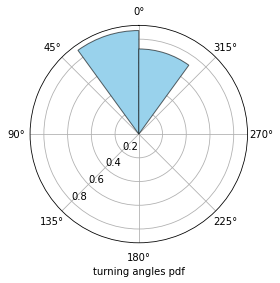

In [6]:
if len(flights_sample) > 0:
    theta = turning_angles_ensemble(list(map(lambda flight: flight.y_traj, flights_sample)))
    plot_angles_hist(theta, 10)

#### **Wing Flap Frequency / Bird Size**

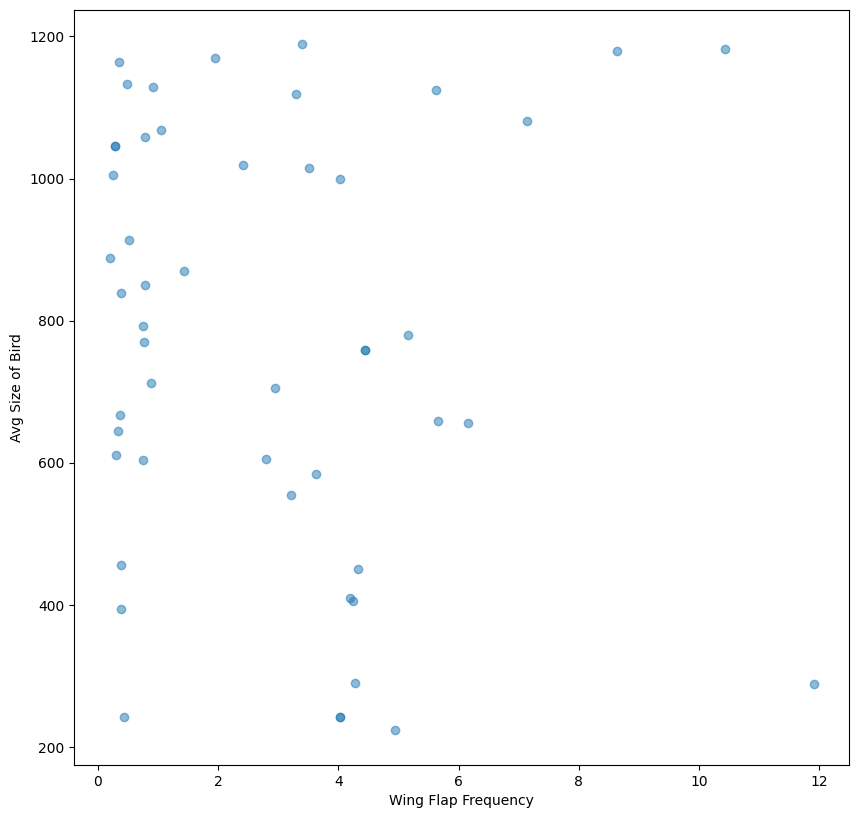

In [7]:
data = [[flight.wing_flap_frequency, flight.avg_size] for flight in flights_sample]

x, y = zip(*data)
figure(figsize=(10, 10), dpi=100)
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Wing Flap Frequency')
plt.ylabel('Avg Size of Bird')
plt.show()

#### **Cluster by Shape**

3
50
28


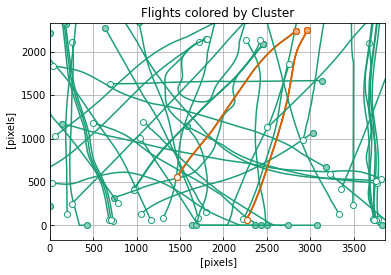

In [8]:
labels = list(flights_sample[0].straightness_dict.keys())
data = list(map(lambda flight: list(flight.straightness_dict.values()), flights_sample))

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=5)

clusterer.fit(data)
print(len(set(clusterer.labels_)))
print(len(data))
print(len(labels))
cluster_names = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t",
                 "u", "v", "w", "x", "y", "x"]
cluster_colors = [plt.cm.Dark2(label) for label in clusterer.labels_]

plot_2D(list(map(lambda flight: flight.y_traj, flights_sample)),
        color=cluster_colors, title="Flights colored by Cluster",legend=False)


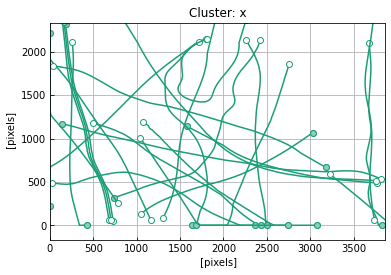

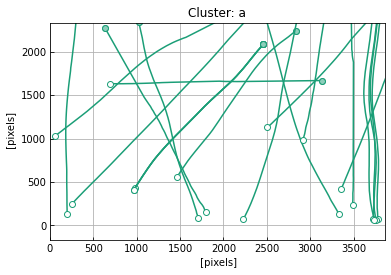

In [9]:
for label in range(-1, max(clusterer.labels_)):
    filtered_by_cluster = np.array(flights_sample)[clusterer.labels_ == label]

    plot_2D(list(map(lambda flight: flight.y_traj, filtered_by_cluster)),
            color=[plt.cm.Dark2(label) for i in filtered_by_cluster], title=f"Cluster: {cluster_names[label]}" ,legend=False)

## Pack if Birds
### 1 Possible Pack of Datasets

*Create Dataset (not important for you)*

In [10]:
from birdwatchpy.config import get_local_data_path

def sequence_id_key_fun(flight: BirdFlightData):
    return flight.sequence_id

sample_sorted_by_seq_id = sorted(flights_sample, key=sequence_id_key_fun)
sample_grouped_by_seq_id = itertools.groupby(sample_sorted_by_seq_id, key=lambda flight: flight.sequence_id)
sample_sorted_by_bird_count = sorted([list(bird_list) for sequence_id, bird_list in sample_grouped_by_seq_id], key = lambda bird_list: len(bird_list), reverse=True)

*Interactive Output function. Everything wich is put in this function. Will be run and shown if the buttons below are pressed*

In [11]:
def update_output_POB():
    output_POB.clear_output()

    with output_POB:
        print(f"Sequence Name: {current_POB[0].sequence_id}")
        
        
        print(len(current_POB))
        print(current_index_POB)
        plot_2D([flight.y_traj for flight in current_POB], title="Single Flight", legend=False)

In [12]:


current_index_POB = -1
current_POB = sample_sorted_by_bird_count[current_index_POB]

output_POB = widgets.Output(layout={'border': '1px solid black'})



def on_button_next_POB(value):
    global current_index_POB
    current_index_POB += 1
    if current_index_POB > len(flights_sample)-1:
        current_index_POB = 0

    global current_POB
    current_POB = sample_sorted_by_bird_count[current_index_POB]

    update_output_POB()


def on_button_prev_POB(value):
    global current_index_POB
    if current_index_POB < 0:
        current_index_POB = len(flights_sample)

    global current_POB
    current_POB = sample_sorted_by_bird_count[current_index_POB]

    update_output_POB()


button_next_POB = ipywidgets.Button(description="Next", )
button_prev_POB = ipywidgets.Button(description="Prev")

display(ipywidgets.HBox([button_prev_POB, button_next_POB]))

button_next_POB.on_click(on_button_next_POB)
button_prev_POB.on_click(on_button_prev_POB)

display(output_POB)

on_button_next_POB("")

Output(layout=Layout(border='1px solid black'))

## Single Flight Analysis


### 1 Flight Selection

In [13]:
from birdwatchpy.config import get_local_data_path

current_index = -1
single_flight = flights_sample[current_index]

output_current_flight = widgets.Output(layout={'border': '1px solid black'})



def update_output_current_flight():
    output_current_flight.clear_output()

    with output_current_flight:
        plot_2D(single_flight.y_traj, title="Single Flight", legend=True)
        print(f"Sequence ID: {single_flight.sequence_id}")
        print(single_flight.get_basic_table())
        
        
        for i in range(4):
            path_to_image = get_local_data_path() / "sequences" / "images"/ f"{single_flight.sequence_id}-{single_flight.frame_numbers[i]}.png"
            if path_to_image.exists():
                Image(filename=path_to_image)
            else:
                print(f"Image not found locally! Path: {path_to_image.as_posix()}")
        #x = PrettyTable()
        #x.field_names = ["Sequence ID"]
        #x.add_row([single_flight.sequence_id])
        #print(x)


def on_button_next_POB(value):
    global current_index
    current_index += 1
    if current_index > len(flights_sample)-1:
        current_index = 0

    global single_flight
    single_flight = flights_sample[current_index]

    update_output_current_flight()


def on_button_prev_POB(value):
    global current_index
    if current_index < 0:
        current_index = len(flights_sample)

    global single_flight
    single_flight = flights_sample[current_index]

    update_output_current_flight()


def on_button_random(value):
    global current_index
    current_index = random.randrange(0, len(flights_sample))

    global single_flight
    single_flight = flights_sample[current_index]

    update_output_current_flight()


button_next = ipywidgets.Button(description="Next", )
button_prev = ipywidgets.Button(description="Prev")
button_random = ipywidgets.Button(description="Random")

display(ipywidgets.HBox([button_prev, button_random, button_next]))

button_next.on_click(on_button_next_POB)
button_random.on_click(on_button_random)
button_prev.on_click(on_button_prev_POB)

display(output_current_flight)

on_button_next_POB("")

Output(layout=Layout(border='1px solid black'))

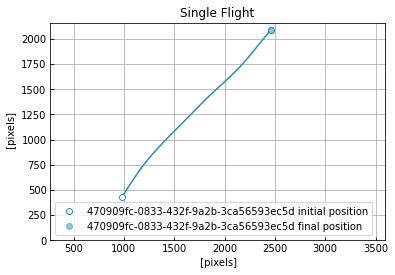

Sequence ID: zoex32k_1653019988_0098181_0098395
+---------------+---------+
|          Stat |   Value |
+---------------+---------+
| Mean Velocity |    8.14 |
|    Mean Speed |   11.56 |
|  Displacement | 2224.97 |
|        Length | 2231.64 |
|     Avg. Size |   223.2 |
+---------------+---------+
Image not found locally! Path: /media/fids/work_ssd/tmp/sequences/images/zoex32k_1653019988_0098181_0098395-98202.png
Image not found locally! Path: /media/fids/work_ssd/tmp/sequences/images/zoex32k_1653019988_0098181_0098395-98203.png
Image not found locally! Path: /media/fids/work_ssd/tmp/sequences/images/zoex32k_1653019988_0098181_0098395-98204.png
Image not found locally! Path: /media/fids/work_ssd/tmp/sequences/images/zoex32k_1653019988_0098181_0098395-98205.png


In [14]:
plot_2D(single_flight.y_traj, title="Single Flight", legend=True)
print(f"Sequence ID: {single_flight.sequence_id}")
print(single_flight.get_basic_table())


for i in range(4):
    path_to_image = get_local_data_path() / "sequences" / "images"/ f"{single_flight.sequence_id}-{single_flight.frame_numbers[i]}.png"
    if path_to_image.exists():
        Image(filename=path_to_image)
    else:
        print(f"Image not found locally! Path: {path_to_image.as_posix()}")

#### Flight

In [15]:
sequence_dir_path = []  # ToDo: implement uri fetcher
video_path = f"{sequence_dir_path}.webm"
if Path(video_path).is_file():
    Video(video_path)
    print(video_path)
else:
    print(f"webm video not found: {video_path}")

webm video not found: [].webm


##### Bird size

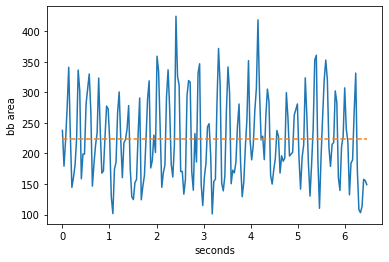

In [16]:

N = len(single_flight.sizes)

x = np.linspace(0, len(single_flight.sizes) * 1 / 30, len(single_flight.sizes))
plt.xlabel('seconds')
plt.ylabel('bb area')
plt.plot(x, single_flight.sizes, x, np.repeat(single_flight.avg_size, len(single_flight.sizes)), '--')

Text(0, 0.5, 'pixel')

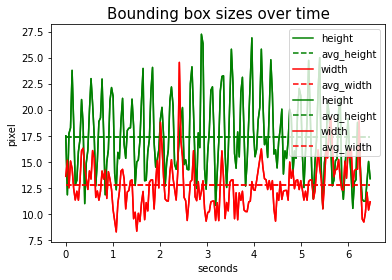

In [17]:
x = np.linspace(0, len(single_flight.sizes) * 1 / 30, len(single_flight.sizes))

heights = [bb.height for bb in single_flight.bounding_boxes]
widths = [bb.width for bb in single_flight.bounding_boxes]
avg_height = np.repeat(np.average(heights), len(single_flight.sizes))
avg_width = np.repeat(np.average(widths), len(single_flight.sizes))
plt.plot(x, heights, "g", label="height")
plt.plot(x, avg_height, 'g--', label="avg_height")
plt.plot(x, widths, "r", label="width")
plt.plot(x, avg_width, 'r--', label="avg_width")

plt.legend()
plt.title("Bounding box sizes over time", fontsize=15)

plt.xlabel('seconds')
plt.ylabel('pixel')

x = np.linspace(0, len(single_flight.sizes) * 1 / 30, len(single_flight.sizes))

heights = [bb.height for bb in single_flight.bounding_boxes]
widths = [bb.width for bb in single_flight.bounding_boxes]
avg_height = np.repeat(np.average(heights), len(single_flight.sizes))
avg_width = np.repeat(np.average(widths), len(single_flight.sizes))
plt.plot(x, heights, "g", label="height")
plt.plot(x, avg_height, 'g--', label="avg_height")
plt.plot(x, widths, "r", label="width")
plt.plot(x, avg_width, 'r--', label="avg_width")

plt.legend()
plt.title("Bounding box sizes over time", fontsize=15)

plt.xlabel('seconds')
plt.ylabel('pixel')



##### Wing Flap Frequency

In [18]:
sizes = np.array(single_flight.sizes)
positions_count = single_flight.positions_counts



AttributeError: 'BirdFlightData' object has no attribute 'positions_counts'

In [ ]:
print(single_flight.sizes)

##### Histogram of Velocity

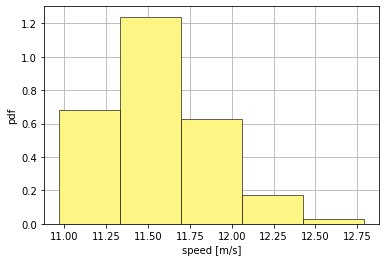

In [19]:
v = speed_ensemble([single_flight.y_traj], step=1)
plot_velocity_hist(v, bins=5)

In [20]:
##### Histogram of Turning Angles

/home/jo/.var/app/com.jetbrains.PyCharm-Professional/data/virtualenvs/fids_bird_detection_and_tracking-jrQ4Gl_l/lib/python3.9/site-packages/yupi/graphics/_stats_plots.py:138: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection="polar")


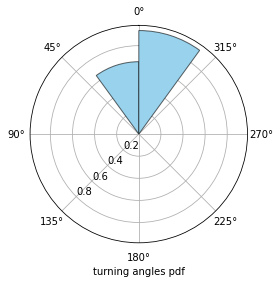

In [21]:
from yupi.graphics import plot_angles_hist
from yupi.stats import turning_angles_ensemble

theta = turning_angles_ensemble([single_flight.y_traj])
plot_angles_hist(theta, 10)

##### Straightness

In [22]:
print(single_flight.get_straightness_tables())


+---------+---------+
| Field 1 | Field 2 |
+---------+---------+
|     1/1 | 0.99701 |
|     1/2 | 0.99658 |
|     2/2 | 0.99842 |
|     1/3 | 0.99734 |
|     2/3 | 0.99975 |
|     3/3 | 0.99845 |
|     1/4 |  0.9985 |
|     2/4 | 0.99988 |
|     3/4 | 0.99972 |
|     4/4 | 0.99935 |
|     1/5 | 0.99928 |
|     2/5 | 0.99958 |
|     3/5 | 0.99992 |
|     4/5 | 0.99961 |
|     5/5 | 0.99977 |
|     1/6 | 0.99965 |
|     2/6 | 0.99938 |
|     3/6 | 0.99997 |
|     4/6 | 0.99967 |
|     5/6 | 0.99921 |
|     6/6 | 0.99982 |
|     1/7 | 0.99975 |
|     2/7 | 0.99915 |
|     3/7 | 0.99993 |
|     4/7 | 0.99997 |
|     5/7 |  0.9999 |
|     6/7 |   0.999 |
|     7/7 | 0.99982 |
+---------+---------+


Flight Data json export

In [23]:
print(single_flight.as_dict())

{'flight_id': '470909fc-0833-432f-9a2b-3ca56593ec5d', 'sequence_id': 'zoex32k_1653019988_0098181_0098395', 'gt_is_bird': None, 'frame_numbers': [98202, 98203, 98204, 98205, 98206, 98207, 98208, 98209, 98210, 98211, 98212, 98213, 98214, 98215, 98216, 98217, 98218, 98219, 98220, 98221, 98222, 98223, 98224, 98225, 98226, 98227, 98228, 98229, 98230, 98231, 98232, 98233, 98234, 98235, 98236, 98237, 98238, 98239, 98240, 98241, 98242, 98243, 98244, 98245, 98246, 98247, 98248, 98249, 98250, 98251, 98252, 98253, 98254, 98255, 98256, 98257, 98258, 98259, 98260, 98261, 98262, 98263, 98264, 98265, 98266, 98267, 98268, 98269, 98270, 98271, 98272, 98273, 98274, 98275, 98276, 98277, 98278, 98279, 98280, 98281, 98282, 98283, 98284, 98285, 98286, 98287, 98288, 98289, 98290, 98291, 98292, 98293, 98294, 98295, 98296, 98297, 98298, 98299, 98300, 98301, 98302, 98303, 98304, 98305, 98306, 98307, 98308, 98309, 98310, 98311, 98312, 98313, 98314, 98315, 98316, 98317, 98318, 98319, 98320, 98321, 98322, 98323, 9

#### Environment

- [] De-hardcode timestamp

In [29]:
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from birdwatchpy.environment.EnvironmentData import EnvironmentData


environment_data = EnvironmentData.from_db( time.time())
print(environment_data.as_dict())
with open( "environment_data.json", "w") as outfile:
    json.dump(environment_data.as_dict(), outfile)
#environment_data = EnvironmentData.from_db(datetime.now())# time.time())

LocationInfo(name='Berlin', region='Germany', timezone='Europe/Berlin', latitude=52.5, longitude=13.416666666666666)
None
Europe/Berlin
Europe/Berlin
Europe/Berlin
<class 'datetime.datetime'>
<class 'datetime.datetime'>
Europe/Berlin
Europe/Berlin
<class 'datetime.datetime'>
<class 'datetime.datetime'>
Europe/Berlin
Europe/Berlin
<class 'datetime.datetime'>
<class 'datetime.datetime'>
Europe/Berlin
Europe/Berlin
<class 'datetime.datetime'>
<class 'datetime.datetime'>
Europe/Berlin
Europe/Berlin
<class 'datetime.datetime'>
<class 'datetime.datetime'>
{'datetime': '2022-07-09 16:14:15.484560', 'position': {'latitude': 53.54221, 'longitude': 9.99079}, 'temperature': 19.3, 'humidity': 56, 'wind_speed': 3.7, 'gust_speed': 6.1, 'wind_direction': 'NW', 'avg_illuminance': {'timestamp': 1657376053.818342, 'avg_lx': 3155.7739999999962}, 'magnetic_field': {'timestamp': 1657376053.8913684, 'x': -118, 'y': 460, 'z': 238}, 'air_pressure_measurements': [(1657376036.7939181, 1025.396), (1657375775.487

303.8597499104239
-56.14025008957612
Dir: NO
flight_angle: 48.247137783868475
flight_direction: -56.14025008957612
north_angle: 104.3873878734446
{'N': 0.0, 'NNW': 22.5, 'NW': 45.0, 'WNW': 67.5, 'W': 90.0, 'WSW': 112.5, 'SW': 135.0, 'SSW': 157.5, 'S': 180.0, 'SSE': 202.5, 'SE': 225.0, 'ESE': 247.5, 'E': 270.0, 'ENE': 292.5, 'NE': 315.0, 'NNE': 337.5}
Wind in deg: 0.7853981633974483
-56.14025008957612
303.8597499104239
-56.14025008957612
NO
Flight Angle -56.14025008957612
Wind Angle 0.7853981633974483
56.925648252973566


/home/jo/coding_projects/fids_bird_detection_and_tracking/birdwatchpy/helper/polar/viz.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['N', 'NW', 'W', 'SW', 'S', 'SE', 'E', 'NO'])


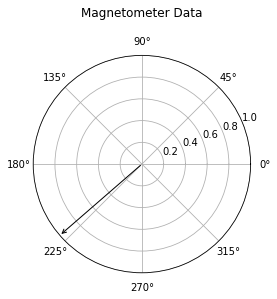

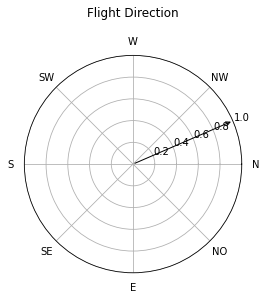

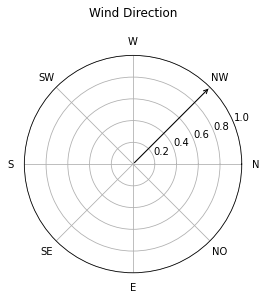

In [30]:
from birdwatchpy.helper.polar.conversion import angle_lookup, direction_lookup
from birdwatchpy.helper.polar.viz import compass
import math

fig, ax = compass([environment_data.get_north_angle()], [1], title = "Magnetometer Data" )

if single_flight.flight_direction is not None:
    fig, ax = compass([single_flight.flight_direction], [1] ,  title ="Flight Direction in Footage")

flight_angle, flight_direction = single_flight.set_flight_direction(environment_data)
north_angle = environment_data.get_north_angle()
print(f"Dir: {single_flight.get_flight_direction_char()}")


if flight_angle is not None and flight_direction is not None:
    print(f"flight_angle: {flight_angle}")
    print(f"flight_direction: {flight_direction}")
    print(f"north_angle: {north_angle}")


    wind_dir_angle = angle_lookup(environment_data.wind_direction)
    print(f"Wind in deg: {wind_dir_angle}")

    print(flight_angle-north_angle)
    print(direction_lookup(flight_angle-north_angle))

    flight_dir_angle = flight_angle-north_angle
    print(f"Flight Angle {flight_dir_angle}")
    print(f"Wind Angle {wind_dir_angle}")
    print(abs(flight_dir_angle-wind_dir_angle))

    fig, ax = compass([flight_dir_angle], [1],  title ="Flight Direction",show_direction_labels=True)
    fig, ax = compass([wind_dir_angle], [1],  title ="Wind Direction",show_direction_labels=True)

In [31]:
def get_basic_environment_info_table(environment_data: EnvironmentData):
    x = PrettyTable()

    x.align = "r"
    x.field_names = ["Stat", "Value"]
    x.add_row(["datetime",environment_data.datetime])
    x.add_row(["position", f"lat: {environment_data.position['latitude']} long: {environment_data.position['longitude']}"])

    x.add_row(["datetime", environment_data.datetime])
    x.add_row(["temperature", round(abs(environment_data.temperature), 2)])
    x.add_row(["humidity", round(float(environment_data.humidity), 2)])
    x.add_row(["wind_speed", round(environment_data.wind_speed, 2)])
    x.add_row(["gust_speed", round(environment_data.gust_speed, 2)])
    x.add_row(["wind_direction", environment_data.wind_direction])
    x.add_row(["avg_illuminance", round(environment_data.avg_illuminance["avg_lx"], 2)])
    x.add_row(["magnetic_field", f"x: {environment_data.magnetic_field['x']}, y: {environment_data.magnetic_field['y']},z: {environment_data.magnetic_field['z']}"])

    for key, value in environment_data.astral_info.items():
        x.add_row([key, value])

    return x

print(get_basic_environment_info_table(environment_data))

+-----------------+-----------------------------+
|            Stat |                       Value |
+-----------------+-----------------------------+
|        datetime |  2022-07-09 16:14:15.484560 |
|        position | lat: 53.54221 long: 9.99079 |
|        datetime |  2022-07-09 16:14:15.484560 |
|     temperature |                        19.3 |
|        humidity |                        56.0 |
|      wind_speed |                         3.7 |
|      gust_speed |                         6.1 |
|  wind_direction |                          NW |
| avg_illuminance |                     3155.77 |
|  magnetic_field |      x: -118, y: 460,z: 238 |
|     is_twilight |                       False |
|        is_night |                       False |
|     is_daylight |                        True |
|    is_blue_hour |                       False |
|  is_golden_hour |                       False |
|      moon_phase |           9.366777777777779 |
|     m_till_dawn |               -848.19778515 |


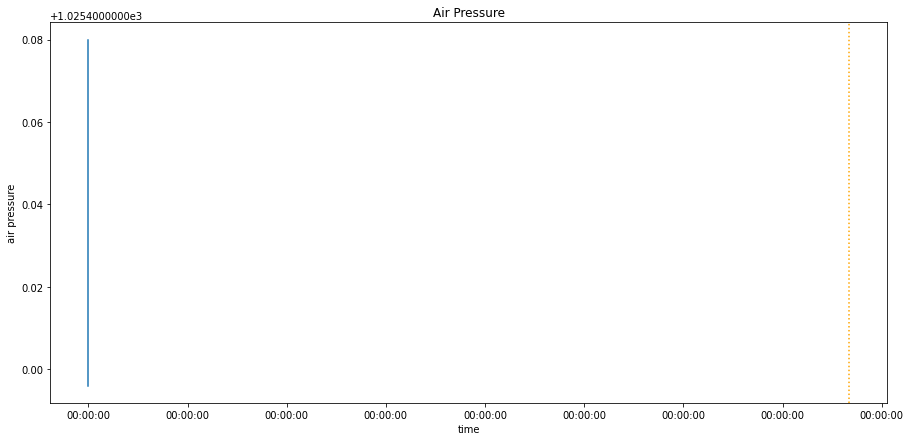

In [32]:

if len(environment_data.air_pressure_measurements) > 0:
    x,y = zip(*environment_data.air_pressure_measurements)
    x = mdates.date2num(x)

    plt.figure(figsize=((15), (7)))
    plt.plot(x, y)

    plt.axvline(x=mdates.date2num([environment_data.datetime]), color='orange', linestyle='dotted')

    plt.xlabel("time")
    plt.ylabel("air pressure")
    plt.title("Air Pressure")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    plt.show()

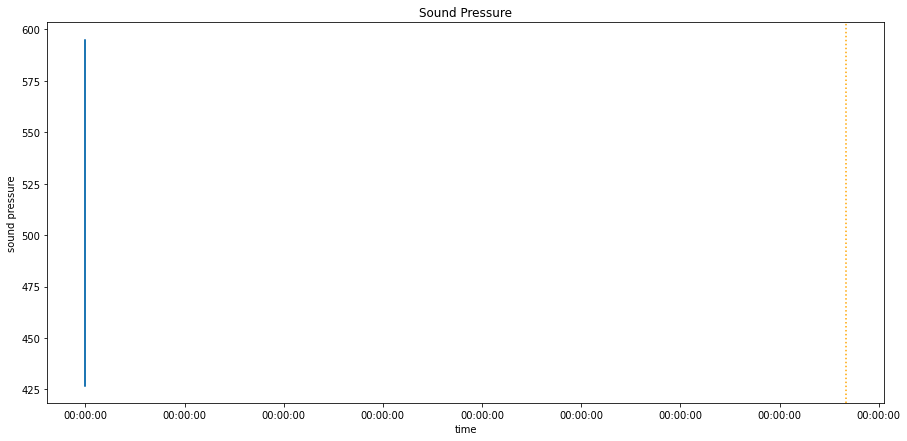

In [33]:
if len(environment_data.avg_sound_pressure_measurements) > 0:
    x,y = zip(*environment_data.avg_sound_pressure_measurements)
    x = mdates.date2num(x)

    plt.figure(figsize=((15), (7)))
    plt.plot(x, y)

    plt.axvline(x=mdates.date2num([environment_data.datetime]), color='orange', linestyle='dotted')

    plt.xlabel("time")
    plt.ylabel("sound pressure")
    plt.title("Sound Pressure")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    plt.show()

Environment Data json Export

In [34]:
print(environment_data.__dict__)

{'datetime': datetime.datetime(2022, 7, 9, 16, 14, 15, 484560), 'position': {'latitude': 53.54221, 'longitude': 9.99079}, 'temperature': 19.3, 'humidity': 56, 'wind_speed': 3.7, 'gust_speed': 6.1, 'wind_direction': 'NW', 'avg_illuminance': {'timestamp': 1657376053.818342, 'avg_lx': 3155.7739999999962}, 'magnetic_field': {'timestamp': 1657376053.8913684, 'x': -118, 'y': 460, 'z': 238}, 'air_pressure_measurements': [(1657376036.7939181, 1025.396), (1657375775.487412, 1025.48)], 'avg_sound_pressure_measurements': [(1657376053.949614, 470.64), (1657376053.7380598, 452.17), (1657376053.5951326, 449.15), (1657376053.4151871, 427.14), (1657376053.2708075, 443.31), (1657376053.1090107, 426.88), (1657376052.957494, 437.69), (1657376052.8019161, 435.76), (1657376052.6222465, 451.86), (1657376052.422084, 437.36), (1657376050.430128, 446.97), (1657376050.296871, 452.97), (1657376050.1621249, 442.59), (1657376050.0231724, 450.54), (1657376049.8716705, 441.4), (1657376049.723587, 456.86), (165737604

# FIDS text generation

#### Context aware Text Generator

##### Single Flight

In [35]:
from birdwatchpy.text_generation.context_aware_productions_manipulation import process_single_flight
from birdwatchpy.text_generation.grammar import create_normalized_PCFG_str, write_all_sentence_possibilities, \
    generate_pcfg_sentences
from birdwatchpy.text_generation.productions import create_productions_dict
from birdwatchpy.text_generation.grammar import pcfg_from_str
from birdwatchpy.text_generation.productions import load_sentence_prods_from_csv, load_terminal_prods_from_csv
from birdwatchpy.text_generation.productions import as_one_to_one_productions_list
from birdwatchpy.utils import get_project_root
from birdwatchpy.text_generation.productions_set_check import check_productions, check_plausability_predicate
from pcfg import PCFG


sentence_prods=load_sentence_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'sentence_prod.csv')
terminal_prods = load_terminal_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'terminal_prod.csv')

processed_productions = process_single_flight("", environment=environment_data, flight=single_flight,sentence_productions_list=sentence_prods,
terminal_productions_list=terminal_prods)

prods_dict = create_productions_dict(as_one_to_one_productions_list(processed_productions))


print("prods_dict")
print(prods_dict)
pcfg_str = create_normalized_PCFG_str(prods_dict)
pcfg = pcfg_from_str(pcfg_str)

print(type(pcfg))

retry_counter = 0
while True:
    try:
        sentence = pcfg.generate(3)
        #sentence = generate_pcfg_sentences(pcfg, 1)
        print(list(sentence))
        break
    except KeyError:
        if retry_counter >40:
            print('Max sentence generation retries reached.')
            break
        continue

Processor not found: is_bird_sound_processor
Processor not found: is_bird_sound_processor
Processor not found: is_bird_sound_processor
Processor not found: is_bird_sound_processor
Processor not found: is_bird_sound_processor
Processor not found: is_bird_sound_processor
Arg processor not found: flight_shape
Arg processor not found: flap_steadiness_perecentile_lt
Arg processor not found: flap_steadiness_perecentile_lt
Arg processor not found: flap_steadiness_perecentile_lt
Arg processor not found: flap_steadiness_perecentile_gt
Arg processor not found: flap_steadiness_perecentile_gt
Arg processor not found: flap_steadiness_perecentile_gt
Arg processor not found: flap_steadiness_perecentile_lt
Arg processor not found: flap_steadiness_perecentile_lt
Arg processor not found: flap_steadiness_perecentile_lt
Arg processor not found: light_percentile_gt
Arg processor not found: light_percentile_gt
Arg processor not found: light_percentile_gt
Arg processor not found: light_percentile_gt
Arg proc

##### Bird Sound

In [36]:
from birdwatchpy.text_generation.context_aware_productions_manipulation import process_single_flight, create_audio_based_productions
from birdwatchpy.text_generation.grammar import create_normalized_PCFG_str, write_all_sentence_possibilities, \
    generate_pcfg_sentences
from birdwatchpy.text_generation.productions import create_productions_dict
from birdwatchpy.text_generation.grammar import pcfg_from_str
from birdwatchpy.text_generation.productions import load_sentence_prods_from_csv, load_terminal_prods_from_csv
from birdwatchpy.text_generation.productions import as_one_to_one_productions_list
from birdwatchpy.utils import get_project_root
from birdwatchpy.text_generation.productions_set_check import check_productions, check_plausability_predicate
from pcfg import PCFG


sentence_prods=load_sentence_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'sentence_prod.csv')
terminal_prods = load_terminal_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'terminal_prod.csv')

processed_productions = create_audio_based_productions(environment=environment_data,sentence_productions_list=sentence_prods,
terminal_productions_list=terminal_prods)

prods_dict = create_productions_dict(as_one_to_one_productions_list(processed_productions))


pcfg_str = create_normalized_PCFG_str(prods_dict)
pcfg = pcfg_from_str(pcfg_str)

print('pcfg')
print(pcfg)
print(type(pcfg))

retry_counter = 0
while True:
    try:
        sentence = pcfg.generate(15)
        #sentence = generate_pcfg_sentences(pcfg, 1)
        print(list(sentence))
        break
    except KeyError:
        if retry_counter >40:
            print('Max sentence generation retries reached.')
            break
        continue

print(environment_data.astral_info)

Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
prod is SentenceProduction(left='S', right=['SS_SOUND_SI'], weight=1.0, processor='is_bird_sound_processor', processor_args={})
Append SentenceProduction(left='S', right=['SS_SOUND_SI'], weight=1.0, processor='is_bird_sound_processor', processor_args={})
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_count_processor
prod is None
Processor not found: bird_coun

In [37]:

from textwrap import TextWrapper
import random

def rewrite_at(index, replacements, the_list):
    del the_list[index]
    the_list[index:index] = replacements

def generate_sentence(grammar):
    sentence_list = [grammar.start()]
    all_terminals = False
    while not all_terminals:
        all_terminals = True
        for position, symbol in enumerate(sentence_list):
            if symbol in grammar._lhs_index:
                all_terminals = False
                derivations = grammar._lhs_index[symbol]
                derivation = random.choice(derivations) # or weighted_choice(derivations) if you have a function for that
                rewrite_at(position, derivation.rhs(), sentence_list)
    return sentence_list


sentence_list =  [generate_sentence(grammar) for i in range(5)]
print(sentence_list)





#text_binary_converted = ' '.join(format(c, 'b') for c in bytearray(text, "utf-8"))
text_binary_converted = bytes(text, "utf-8") #' '.join(format(c, 'b') for c in bytearray(text, "utf-8"))


NameError: name 'grammar' is not defined

In [ ]:
from text_generation.grammar import cfg_from_str, cfg_str_from_productions, write_all_sentence_possibilities
from text_generation.productions import load_sentence_prods_from_csv, load_terminal_prods_from_csv
from text_generation.productions_set_check import check_productions
from utils import get_project_root

productions=load_sentence_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'sentence_prod.csv') + load_terminal_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'terminal_prod.csv')

check_productions(productions)

cfg_str = cfg_str_from_productions(productions)

cfg_str = cfg_str.replace("'{", "'")
cfg_str = cfg_str.replace("}'", "'")

cfg=cfg_from_str(cfg_str)


print_and_write_all = False
if print_and_write_all:
    write_all_sentence_possibilities(cfg)


In [ ]:
from text_generation.grammar import create_normalized_PCFG_str, write_all_sentence_possibilities, \
    generate_pcfg_sentences
from text_generation.productions import create_productions_dict
from text_generation.grammar import pcfg_from_str
from text_generation.productions import load_sentence_prods_from_csv, load_terminal_prods_from_csv
from text_generation.productions import as_one_to_one_productions_list
from utils import get_project_root
from text_generation.productions_set_check import check_productions
from pcfg import PCFG

productions=load_sentence_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'sentence_prod.csv') + load_terminal_prods_from_csv(get_project_root() / 'birdwatchpy' / 'text_generation' / 'terminal_prod.csv')

check_productions(productions)

prods_dict = create_productions_dict(as_one_to_one_productions_list(productions))
pcfg_str = create_normalized_PCFG_str(prods_dict)

pcfg_str = pcfg_str.replace("'{", "'")
pcfg_str = pcfg_str.replace("}'", "'")

pcfg = pcfg_from_str(pcfg_str)
print(type(pcfg))
for sentence in generate_pcfg_sentences(pcfg, 10):
     print(sentence)



#write_all_sentence_possibilities(pcfg)

In [ ]:

from database.fids_text import insert_sentence_entry, get_latest_sentence_entries
import time

for sentence in generate_pcfg_sentences(pcfg, 10):
     insert_sentence_entry({"timestamp": time.time(), "sentence":sentence})

for s in  get_latest_sentence_entries(time.time(), 10):
    print(s)

In [ ]:
from text_generation.grammar import pcfg_from_str
from pcfg import PCFG

processed_productions = process_single_flight("", environment=environment_data, flight=single_flight)
processed_productions = [prod for prod in processed_productions if prod is not None]
one_to_one_productions = as_one_to_one_productions_list(processed_productions)

#one_to_one_productions = [prod for prod in one_to_one_productions if recursive_check_forward_plausible(prod,one_to_one_productions)]

PCFG_grammar = pcfg_from_str(create_normalized_PCFG_str(one_to_one_productions))

print_and_write_all = True
if print_and_write_all:
    write_all_sentence_possibilities(cfg)

In [ ]:
print(PCFG_grammar.start())
for n, sent in enumerate(generate(PCFG_grammar, n=10000000), 1):
    print("%3d. %s" % (n, " ".join(sent)))


In [ ]:
text= """
page 1000ms
75 Der Himmel ist hell. Aber der sehr schnelle NN_BIRD_SI_F sieht
75 schlecht.
75 Richtung Spitzbergen segelt gerade mit steten Flügelschlägen nur
75 ein Tier.
75 über den Himmel zischen mit lahmen Flügelschlägen 23 Punkte.
00
75 Der Himmel ist schwarz. nicht schlecht ist der flotte Vogel zu
75 schauen.
75 Richtung England gleiten in einem Bogen 6 flotte Linien mit
75 steten Flügelschlägen.

page 1000ms
75 mit {flaps_sec} Flügelschlägen pro Sekunde zieht gerade ATT_TIME
75 1 NN_BIRD_SI_F über den Himmel.
75 Wenn es sehr kalt wird  treiben die Punkte gen Nord. warum ?
00
75 Richtung Elbemündung schweben ATT_TIME  viele Punkte.
00
75  viele Striche segeln in einem Bogen gen Nord.
00
75 20 Vögel segeln mit {flaps_sec} Flügelschlägen pro Sekunde gen
75 Finkenwerder.
end
"""
text_binary_converted = bytes(text, "utf-8") #' '.join(format(c, 'b') for c in bytearray(text, "utf-8"))

TCP Client

In [ ]:
import socket

#host = "51.195.44.112"
host = "195.160.172.5"
port = 1234
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((host, port))
s.sendall(text_binary_converted)
data = s.recv(1024)
s.close()

In [ ]:
# Check Terminal Coverage
grammar.check_coverage({right_list for prod in terminal_productions_list for right_list in prod.right})

grammar.check_coverage({right_list for prod in sentence_productions_list for right_list in prod.right})

In [ ]:
from nltk import PCFG
from nltk.parse.generate import generate

grammar_str = """
S  -> SS_SI [1.00000000000000000000]
ADJ_SPEED_SI_NOM -> lahme [0.25000000000000000000]
ADJ_SPEED_SI_NOM -> sehr langsame [0.25000000000000000000]
ADJ_SPEED_SI_NOM -> langsame [0.25000000000000000000]
ADJ_SPEED_SI_NOM -> gemächliche [0.25000000000000000000]
ADJ_SPEED_SI_M -> lahmer [0.25000000000000000000]
ADJ_SPEED_SI_M -> sehr langsamer [0.25000000000000000000]
ADJ_SPEED_SI_M -> langsamer [0.25000000000000000000]
ADJ_SPEED_SI_M -> gemächlicher [0.25000000000000000000]
ADJ_SPEED_SI_N -> lahmes [0.25000000000000000000]
ADJ_SPEED_SI_N -> sehr langsames [0.25000000000000000000]
ADJ_SPEED_SI_N -> langsames [0.25000000000000000000]
ADJ_SPEED_SI_N -> gemächliches [0.25000000000000000000]
ADJ_SPEED_PL -> lahme [0.25000000000000000000]
ADJ_SPEED_PL -> sehr langsame [0.25000000000000000000]
ADJ_SPEED_PL -> langsame [0.25000000000000000000]
ADJ_SPEED_PL -> gemächliche [0.25000000000000000000]
ADJ_SPEED_PL_NOM -> lahmen [0.25000000000000000000]
ADJ_SPEED_PL_NOM -> sehr langsamen [0.25000000000000000000]
ADJ_SPEED_PL_NOM -> langsamen [0.25000000000000000000]
ADJ_SPEED_PL_NOM -> sehr gemächlichen [0.25000000000000000000]
CD_SI -> nur ein [0.33333333333333331483]
CD_SI -> nur ein [0.33333333333333331483]
CD_SI -> nur ein [0.33333333333333331483]
V_SEE_SI -> sieht [0.33333333333333331483]
V_SEE_SI -> erkennt [0.25000000000000000000]
V_SEE_SI -> beobachtet [0.25000000000000000000]
V_SEE_SI -> schaut [0.16666666666666665741]
V_SEE_PL -> sehen [0.33333333333333331483]
V_SEE_PL -> erkennen [0.25000000000000000000]
V_SEE_PL -> beobachten [0.25000000000000000000]
V_SEE_PL -> schauen [0.16666666666666665741]
NN_BIRD_SI_M -> Vogel [1.00000000000000000000]
NN_BIRD_SI_N -> Tier [0.49999500004999947178]
NN_BIRD_SI_N -> Flattertier [0.24999750002499973589]
NN_BIRD_SI_N -> Flugtier [0.24999750002499973589]
NN_BIRD_SI_N -> Ratte der Lüfte [0.00000999990000099999]
NN_BIRD_PL -> Federvieh [1.00000000000000000000]
NN_FLAP_SI -> Flügelschlag [1.00000000000000000000]
NN_FLAP_PL -> Flügelschlägen [1.00000000000000000000]
NN_PLACES -> Horizont [0.50000000000000000000]
NN_PLACES -> Rand der Welt [0.50000000000000000000]
ATT_ORIENT -> vorbei [1.00000000000000000000]
ATT_ORIENT_A -> über den [1.00000000000000000000]
ATT_ORIENT_B -> Himmel [1.00000000000000000000]
ATT_QUAL -> gut [0.20000000000000001110]
ATT_QUAL -> nicht [0.20000000000000001110]
ATT_QUAL -> nicht gut [0.20000000000000001110]
ATT_QUAL -> schlecht [0.20000000000000001110]
ATT_QUAL -> nicht schlecht [0.20000000000000001110]
ATT_TEMP -> lau [0.25000000000000000000]
ATT_TEMP -> frisch [0.25000000000000000000]
ATT_TEMP -> kühl [0.25000000000000000000]
ATT_TEMP -> kalt [0.25000000000000000000]
QUESTION -> warum [1.00000000000000000000]
SS_SI -> CD_SI SUBJ_SI FLIGHT_SI DIR PP [0.06250000000000000000]
SS_SI -> CD_SI SUBJ_SI FLIGHT_SI TIME DIR PP [0.06250000000000000000]
SS_SI -> DIR FLIGHT_SI TIME CD_SI SUBJ_SI PP [0.06250000000000000000]
SS_SI -> DIR FLIGHT_SI CD_SI SUBJ_SI TIME PP [0.06250000000000000000]
SS_SI -> DIR FLIGHT_SI CD_SI SUBJ_SI PP [0.06250000000000000000]
SS_SI -> FLAP FLIGHT_SI CD_SI SUBJ_SI DIR PP [0.06250000000000000000]
SS_SI -> FLAP FLIGHT_SI TIME CD_SI SUBJ_SI DIR PP [0.06250000000000000000]
SS_SI -> CD_SI SUBJ_SI FLIGHT_SI FLAP DIR PP  [0.06250000000000000000]
SS_SI -> CD_SI SUBJ_SI FLIGHT_SI TIME FLAP DIR PP  [0.06250000000000000000]
SS_SI -> DIR FLIGHT_SI FLAP CD_SI SUBJ_SI PP  [0.06250000000000000000]
SS_SI -> DIR FLIGHT_SI TIME FLAP CD_SI SUBJ_SI PP  [0.06250000000000000000]
SS_SI -> DIR FLIGHT_SI CD_SI SUBJ_SI FLAP  PP  [0.06250000000000000000]
SS_SI -> DIR FLIGHT_SI TIME CD_SI SUBJ_SI FLAP  PP  [0.06250000000000000000]
SS_SI -> 'Der' ATT_ORIENT_B 'ist' ADJ_LIGHT_SI PP ATT_QUAL 'ist der' SUBJ_SI_NOM 'zu' V_SEE_PL PP [0.06250000000000000000]
SS_SI -> 'Der' ATT_ORIENT_B 'ist' ADJ_LIGHT_SI PP 'Aber der' SUBJ_SI_NOM V_SEE_SI ATT_QUAL PP [0.06250000000000000000]
SS_SI -> 'Der' ATT_ORIENT_B 'ist' ADJ_LIGHT_SI PP 'Aber der' SUBJ_SI_NOM V_SEE_SI ATT_QUAL PP [0.06250000000000000000]
SS_PL -> CD_PL SUBJ_PL FLIGHT_PL DIR PP  [0.05555555555555555247]
SS_PL -> CD_PL SUBJ_PL FLIGHT_PL TIME DIR PP  [0.05555555555555555247]
SS_PL -> DIR FLIGHT_PL TIME CD_PL SUBJ_PL PP [0.05555555555555555247]
SS_PL -> DIR FLIGHT_PL CD_PL SUBJ_PL TIME PP [0.05555555555555555247]
SS_PL -> DIR FLIGHT_PL CD_PL SUBJ_PL PP [0.05555555555555555247]
SS_PL -> FLAP FLIGHT_PL CD_PL SUBJ_PL DIR PP [0.05555555555555555247]
SS_PL -> FLAP FLIGHT_PL TIME CD_PL SUBJ_PL DIR PP [0.05555555555555555247]
SS_PL -> CD_PL SUBJ_PL FLIGHT_PL FLAP DIR PP  [0.05555555555555555247]
SS_PL -> CD_PL SUBJ_PL FLIGHT_PL TIME FLAP DIR PP  [0.05555555555555555247]
SS_PL -> DIR FLIGHT_PL FLAP CD_PL SUBJ_PL PP  [0.05555555555555555247]
SS_PL -> DIR FLIGHT_PL TIME FLAP CD_PL SUBJ_PL PP  [0.05555555555555555247]
SS_PL -> DIR FLIGHT_PL CD_PL SUBJ_PL FLAP  PP  [0.05555555555555555247]
SS_PL -> DIR FLIGHT_PL TIME CD_PL SUBJ_PL FLAP  PP  [0.05555555555555555247]
SS_PL -> 'Der' ATT_ORIENT_B 'ist' ADJ_LIGHT_SI PP ATT_QUAL 'sind die' SUBJ_PL_NOM 'zu' V_SEE_PL PP [0.05555555555555555247]
SS_PL -> 'Der' ATT_ORIENT_B 'ist' ADJ_LIGHT_SI PP 'Aber die' SUBJ_PL_NOM V_SEE_PL ATT_QUAL PP [0.05555555555555555247]
SS_PL -> 'Wenn es' ATT_TEMP 'wird' CC V_FLIGHT_PL 'die' SUBJ_PL 'gen' NN_ORIENT PP 'Um diese Jahreszeit' QQ [0.05555555555555555247]
SS_PL -> 'Wenn es' ATT_TEMP 'wird' CC V_FLIGHT_PL 'die' SUBJ_PL 'gen' NN_ORIENT PP QUESTION QQ [0.05555555555555555247]
SS_PL -> 'Der' ATT_ORIENT_B 'ist' ADJ_LIGHT_SI PP 'Aber die' SUBJ_PL_NOM V_SEE_PL ATT_QUAL PP [0.05555555555555555247]
DIR -> ORIENT [1.00000000000000000000]
ORIENT -> 'gen' NN_ORIENT [0.14285714285714284921]
ORIENT -> 'gen' NN_PLACES [0.14285714285714284921]
ORIENT -> 'Richtung' NN_ORIENT [0.14285714285714284921]
ORIENT -> 'Richtung' NN_PLACES [0.14285714285714284921]
ORIENT -> ATT_ORIENT [0.14285714285714284921]
ORIENT -> ATT_ORIENT_A ATT_ORIENT_B [0.14285714285714284921]
ORIENT -> ATT_ORIENT_A ADJ_LIGHT_SI_AKK ATT_ORIENT_B [0.14285714285714284921]
FLIGHT_SI -> V_FLIGHT_SI [0.50000000000000000000]
FLIGHT_SI -> V_FLIGHT_SI ATT_FLIGHT [0.50000000000000000000]
FLIGHT_PL -> V_FLIGHT_PL [0.50000000000000000000]
FLIGHT_PL -> V_FLIGHT_PL ATT_FLIGHT [0.50000000000000000000]
FLAP -> 'mit' ADJ_FLAP_PL NN_FLAP_PL [0.50000000000000000000]
FLAP -> 'mit' '{flaps_sec}' NN_FLAP_PL 'pro Sekunde' [0.50000000000000000000]
SUBJ_SI -> SUBJ_SI_M [0.33333333333333331483]
SUBJ_SI -> SUBJ_SI_N [0.33333333333333331483]
SUBJ_SI -> SUBJ_SI_F [0.33333333333333331483]
SUBJ_SI_NOM -> NN_BIRD_SI [0.50000000000000000000]
SUBJ_SI_NOM -> ADJ_SPEED_SI_NOM NN_BIRD_SI [0.50000000000000000000]
SUBJ_SI_M -> NN_BIRD_SI_M [0.45454545454545453032]
SUBJ_SI_M -> NN_SHAPE_SI_M [0.04545454545454545581]
SUBJ_SI_M -> ADJ_SPEED_SI_M NN_BIRD_SI_M [0.45454545454545453032]
SUBJ_SI_M -> ADJ_SPEED_SI_M NN_SHAPE_SI_M [0.04545454545454545581]
SUBJ_SI_N -> NN_BIRD_SI_N [0.45454545454545453032]
SUBJ_SI_N -> NN_SHAPE_SI_N [0.04545454545454545581]
SUBJ_SI_N -> ADJ_SPEED_SI_N NN_BIRD_SI_N [0.45454545454545453032]
SUBJ_SI_N -> ADJ_SPEED_SI_N NN_SHAPE_SI_N [0.04545454545454545581]
SUBJ_SI_F -> NN_BIRD_SI_F [0.45454545454545453032]
SUBJ_SI_F -> NN_SHAPE_SI_F [0.04545454545454545581]
SUBJ_SI_F -> ADJ_SPEED_SI_F NN_BIRD_SI_F [0.45454545454545453032]
SUBJ_SI_F -> ADJ_SPEED_SI_F NN_SHAPE_SI_F [0.04545454545454545581]
SUBJ_PL -> NN_BIRD_PL [0.45454545454545453032]
SUBJ_PL -> NN_SHAPE_PL [0.04545454545454545581]
SUBJ_PL -> ADJ_SPEED_PL NN_BIRD_PL [0.45454545454545453032]
SUBJ_PL -> ADJ_SPEED_PL NN_SHAPE_PL [0.04545454545454545581]
SUBJ_PL_NOM -> NN_BIRD_PL [0.50000000000000000000]
SUBJ_PL_NOM -> ADJ_SPEED_PL_NOM NN_BIRD_PL [0.50000000000000000000]
TIME -> ATT_TIME [1.00000000000000000000]
NN_BIRD_SI -> NN_BIRD_SI_F [0.33333333333333331483]
NN_BIRD_SI -> NN_BIRD_SI_M [0.33333333333333331483]
NN_BIRD_SI -> NN_BIRD_SI_N [0.33333333333333331483]
CC -> ',' [1]
QQ -> '?' [1]
DD -> '.' [1]

"""

# Create grammar
grammar = PCFG.fromstring(grammar_str)

f = open("all_possible_sentences.txt", "w")


#generate_tree(grammar).draw()
for n, sent in enumerate(generate(grammar, n=10000000), 1):
    print("%3d. %s" % (n, " ".join(sent)))
    f.write("%3d. %s" % (n, " ".join(sent)) + "\n")
f.close()

In [ ]:
grammar_str = """
    S -> 'SS_SI'
    S -> 'SS_PL'
    SS_SI -> 'CD_SI SUBJ_SI FLIGHT_SI DIR PP'
    SS_PL -> 'CD_PL SUBJ_PL FLIGHT_PL DIR PP '
    SS_SI -> 'CD_SI SUBJ_SI FLIGHT_SI TIME DIR PP'
    SS_PL -> 'CD_PL SUBJ_PL FLIGHT_PL TIME DIR PP '
    SS_SI -> 'DIR FLIGHT_SI TIME CD_SI SUBJ_SI PP'
    SS_PL -> 'DIR FLIGHT_PL TIME CD_PL SUBJ_PL PP'
    SS_SI -> 'DIR FLIGHT_SI CD_SI SUBJ_SI TIME PP'
    SS_PL -> 'DIR FLIGHT_PL CD_PL SUBJ_PL TIME PP'
    SS_SI -> 'DIR FLIGHT_SI CD_SI SUBJ_SI PP'
    SS_PL -> 'DIR FLIGHT_PL CD_PL SUBJ_PL PP'
    SS_SI -> 'FLAP FLIGHT_SI CD_SI SUBJ_SI DIR PP'
    SS_PL -> 'FLAP FLIGHT_PL CD_PL SUBJ_PL DIR PP'
    SS_SI -> 'FLAP FLIGHT_SI TIME CD_SI SUBJ_SI DIR PP'
    SS_PL -> 'FLAP FLIGHT_PL TIME CD_PL SUBJ_PL DIR PP'
    SS_SI -> 'CD_SI SUBJ_SI FLIGHT_SI FLAP DIR PP '
    SS_PL -> 'CD_PL SUBJ_PL FLIGHT_PL FLAP DIR PP '
    SS_SI -> 'CD_SI SUBJ_SI FLIGHT_SI TIME FLAP DIR PP '
    SS_PL -> 'CD_PL SUBJ_PL FLIGHT_PL TIME FLAP DIR PP '
    SS_SI -> 'DIR FLIGHT_SI FLAP CD_SI SUBJ_SI PP '
    SS_PL -> 'DIR FLIGHT_PL FLAP CD_PL SUBJ_PL PP '
    SS_SI -> 'DIR FLIGHT_SI TIME FLAP CD_SI SUBJ_SI PP '
    SS_PL -> 'DIR FLIGHT_PL TIME FLAP CD_PL SUBJ_PL PP '
    SS_SI -> 'DIR FLIGHT_SI CD_SI SUBJ_SI FLAP  PP '
    SS_PL -> 'DIR FLIGHT_PL CD_PL SUBJ_PL FLAP  PP '
    SS_SI -> 'DIR FLIGHT_SI TIME CD_SI SUBJ_SI FLAP  PP '
    SS_PL -> 'DIR FLIGHT_PL TIME CD_PL SUBJ_PL FLAP  PP '
    SS_SI -> '' Der ' ATT_ORIENT_B ' ist ' ADJ_LIGHT_SI PP ATT_QUAL ' ist der ' SUBJ_SI_NOM ' zu ' V_SEE_PL PP'
    SS_PL -> '' Der ' ATT_ORIENT_B ' ist ' ADJ_LIGHT_SI PP ATT_QUAL ' sind die ' SUBJ_PL_NOM ' zu ' V_SEE_PL PP'
    SS_SI -> '' Der ' ATT_ORIENT_B ' ist ' ADJ_LIGHT_SI PP ' Aber der ' SUBJ_SI_NOM V_SEE_SI ATT_QUAL PP'
    SS_PL -> '' Der ' ATT_ORIENT_B ' ist ' ADJ_LIGHT_SI PP ' Aber die ' SUBJ_PL_NOM V_SEE_PL ATT_QUAL PP'
    SS_PL -> '' Wenn es ' ATT_TEMP ' wird ' CC V_FLIGHT_PL ' die ' SUBJ_PL ' gen ' NN_ORIENT PP ' Um diese Jahreszeit ' QQ'
    SS_PL -> '' Wenn es ' ATT_TEMP ' wird ' CC V_FLIGHT_PL ' die ' SUBJ_PL ' gen ' NN_ORIENT PP QUESTION QQ'
    SS_SI -> '' Der ' ATT_ORIENT_B ' ist ' ADJ_LIGHT_SI PP ' Aber der ' SUBJ_SI_NOM V_SEE_SI ATT_QUAL PP'
    SS_PL -> '' Der ' ATT_ORIENT_B ' ist ' ADJ_LIGHT_SI PP ' Aber die ' SUBJ_PL_NOM V_SEE_PL ATT_QUAL PP'
    DIR -> 'ORIENT'
    ORIENT -> '' gen ' NN_ORIENT'
    ORIENT -> '' gen ' NN_PLACES'
    ORIENT -> '' Richtung ' NN_ORIENT'
    ORIENT -> '' Richtung ' NN_PLACES'
    ORIENT -> 'ATT_ORIENT'
    ORIENT -> 'ATT_ORIENT_A ATT_ORIENT_B'
    ORIENT -> 'ATT_ORIENT_A ADJ_LIGHT_SI_AKK ATT_ORIENT_B'
    FLIGHT_SI -> 'V_FLIGHT_SI'
    FLIGHT_PL -> 'V_FLIGHT_PL'
    FLIGHT_SI -> 'V_FLIGHT_SI ATT_FLIGHT'
    FLIGHT_PL -> 'V_FLIGHT_PL ATT_FLIGHT'
    FLAP -> '' mit ' ADJ_FLAP_PL NN_FLAP_PL'
    FLAP -> '' mit ' ' flaps_sec ' NN_FLAP_PL ' pro Sekunde ''
    SUBJ_SI -> 'SUBJ_SI_M'
    SUBJ_SI -> 'SUBJ_SI_N'
    SUBJ_SI -> 'SUBJ_SI_F'
    SUBJ_SI_NOM -> 'NN_BIRD_SI'
    SUBJ_SI_NOM -> 'ADJ_SPEED_SI_NOM NN_BIRD_SI'
    SUBJ_SI_M -> 'NN_BIRD_SI_M'
    SUBJ_SI_M -> 'NN_SHAPE_SI_M'
    SUBJ_SI_M -> 'ADJ_SPEED_SI_M NN_BIRD_SI_M'
    SUBJ_SI_M -> 'ADJ_SPEED_SI_M NN_SHAPE_SI_M'
    SUBJ_SI_N -> 'NN_BIRD_SI_N'
    SUBJ_SI_N -> 'NN_SHAPE_SI_N'
    SUBJ_SI_N -> 'ADJ_SPEED_SI_N NN_BIRD_SI_N'
    SUBJ_SI_N -> 'ADJ_SPEED_SI_N NN_SHAPE_SI_N'
    SUBJ_SI_F -> 'NN_BIRD_SI_F'
    SUBJ_SI_F -> 'NN_SHAPE_SI_F'
    SUBJ_SI_F -> 'ADJ_SPEED_SI_F NN_BIRD_SI_F'
    SUBJ_SI_F -> 'ADJ_SPEED_SI_F NN_SHAPE_SI_F'
    SUBJ_PL -> 'NN_BIRD_PL'
    SUBJ_PL -> 'NN_SHAPE_PL'
    SUBJ_PL -> 'ADJ_SPEED_PL NN_BIRD_PL'
    SUBJ_PL -> 'ADJ_SPEED_PL NN_SHAPE_PL'
    SUBJ_PL_NOM -> 'NN_BIRD_PL'
    SUBJ_PL_NOM -> 'ADJ_SPEED_PL_NOM NN_BIRD_PL'
    TIME -> 'ATT_TIME'
    NN_BIRD_SI -> 'NN_BIRD_SI_M'
    NN_BIRD_SI -> 'NN_BIRD_SI_F'
    NN_BIRD_SI -> 'NN_BIRD_SI_N'
    ADJ_SPEED_SI_NOM -> 'lahme'
    ADJ_SPEED_SI_M -> 'lahmer'
    ADJ_SPEED_SI_N -> 'lahmes'
    ADJ_SPEED_PL -> 'lahme'
    ADJ_SPEED_PL_NOM -> 'lahmen'
    ADJ_SPEED_SI_NOM -> 'sehr langsame'
    ADJ_SPEED_SI_M -> 'sehr langsamer'
    ADJ_SPEED_SI_N -> 'sehr langsames'
    ADJ_SPEED_PL -> 'sehr langsame'
    ADJ_SPEED_PL_NOM -> 'sehr langsamen'
    ADJ_SPEED_SI_NOM -> 'langsame'
    ADJ_SPEED_SI_M -> 'langsamer'
    ADJ_SPEED_SI_N -> 'langsames'
    ADJ_SPEED_PL -> 'langsame'
    ADJ_SPEED_PL_NOM -> 'langsamen'
    ADJ_SPEED_SI_NOM -> 'flitzende'
    ADJ_SPEED_SI_M -> 'flitzender'
    ADJ_SPEED_SI_N -> 'flitzendes'
    ADJ_SPEED_PL -> 'flitzende'
    ADJ_SPEED_PL_NOM -> 'flitzenden'
    ADJ_SPEED_SI_NOM -> 'sehr schnelle'
    ADJ_SPEED_SI_M -> 'sehr schneller'
    ADJ_SPEED_SI_N -> 'sehr schnelles'
    ADJ_SPEED_PL -> 'sehr schnelle'
    ADJ_SPEED_PL_NOM -> 'sehr schnellen'
    ADJ_SPEED_SI_NOM -> 'schnelle'
    ADJ_SPEED_SI_M -> 'schneller'
    ADJ_SPEED_SI_N -> 'schnelles'
    ADJ_SPEED_PL -> 'schnelle'
    ADJ_SPEED_PL_NOM -> 'schnellen'
    ADJ_SPEED_SI_NOM -> 'flotte'
    ADJ_SPEED_SI_M -> 'flotter'
    ADJ_SPEED_SI_N -> 'flottes'
    ADJ_SPEED_PL -> 'flotte'
    ADJ_SPEED_PL_NOM -> 'flotten'
    ADJ_SPEED_SI_NOM -> 'gemächliche'
    ADJ_SPEED_SI_M -> 'gemächlicher'
    ADJ_SPEED_SI_N -> 'gemächliches'
    ADJ_SPEED_PL -> 'gemächliche'
    ADJ_SPEED_PL_NOM -> 'sehr gemächlichen'
    ADJ_SPEED_SI_NOM -> 'panische'
    ADJ_SPEED_SI_M -> 'panischer'
    ADJ_SPEED_SI_N -> 'panisches'
    ADJ_SPEED_PL -> 'panische'
    ADJ_SPEED_PL_NOM -> 'panischen'
    ATT_FLIGHT -> 'in einem Bogen'
    ATT_FLIGHT -> 'gerade'
    ADJ_FLAP_SI_M -> 'steten'
    ADJ_FLAP_SI_N -> 'steten'
    ADJ_FLAP_PL -> 'steten'
    ADJ_FLAP_SI_M -> 'lahmen'
    ADJ_FLAP_SI_N -> 'lahmen'
    ADJ_FLAP_PL -> 'lahmen'
    ADJ_FLAP_SI_M -> 'sehr langsamen'
    ADJ_FLAP_SI_N -> 'sehr langsamen'
    ADJ_FLAP_PL -> 'sehr langsamen'
    ADJ_FLAP_SI_M -> 'langsamen'
    ADJ_FLAP_SI_N -> 'langsamen'
    ADJ_FLAP_PL -> 'langsamen'
    ADJ_FLAP_SI_M -> 'sehr schnellen'
    ADJ_FLAP_SI_N -> 'sehr schnellen'
    ADJ_FLAP_PL -> 'sehr schnellen'
    ADJ_FLAP_SI_M -> 'schnellen'
    ADJ_FLAP_SI_N -> 'schnellen'
    ADJ_FLAP_PL -> 'schnellen'
    ADJ_FLAP_SI_M -> 'flotten'
    ADJ_FLAP_SI_N -> 'flotten'
    ADJ_FLAP_PL -> 'flotten'
    ADJ_FLAP_SI_M -> 'gemächlichen'
    ADJ_FLAP_SI_N -> 'gemächlichen'
    ADJ_FLAP_PL -> 'gemächlichen'
    ADJ_FLAP_SI_M -> 'unruhigen'
    ADJ_FLAP_SI_N -> 'unruhigen'
    ADJ_FLAP_PL -> 'unruhigen'
    ADJ_FLAP_SI_M -> 'ruhigen'
    ADJ_FLAP_SI_N -> 'ruhigen'
    ADJ_FLAP_PL -> 'ruhigen'
    ADJ_FLAP_SI_M -> 'panischen'
    ADJ_FLAP_SI_N -> 'panischen'
    ADJ_FLAP_PL -> 'panischen'
    ADJ_LIGHT_SI -> 'finster'
    ADJ_LIGHT_SI_M -> 'finsterer'
    ADJ_LIGHT_SI_N -> 'finsteres'
    ADJ_LIGHT_PL -> 'finstere'
    ADJ_LIGHT_SI_AKK -> 'finsteren'
    ADJ_LIGHT_SI -> 'dunkel'
    ADJ_LIGHT_SI_M -> 'dunkler'
    ADJ_LIGHT_SI_N -> 'dunkles'
    ADJ_LIGHT_PL -> 'dunkle'
    ADJ_LIGHT_SI_AKK -> 'dunklen'
    ADJ_LIGHT_SI -> 'grau'
    ADJ_LIGHT_SI_M -> 'grauer'
    ADJ_LIGHT_SI_N -> 'graues'
    ADJ_LIGHT_PL -> 'graue'
    ADJ_LIGHT_SI_AKK -> 'grauen'
    ADJ_LIGHT_SI -> 'hell'
    ADJ_LIGHT_SI_M -> 'heller'
    ADJ_LIGHT_SI_N -> 'helles'
    ADJ_LIGHT_PL -> 'helle'
    ADJ_LIGHT_SI_AKK -> 'hellen'
    ADJ_LIGHT_SI -> 'taghell'
    ADJ_LIGHT_SI_M -> 'tagheller'
    ADJ_LIGHT_SI_N -> 'taghelles'
    ADJ_LIGHT_PL -> 'taghelle'
    ADJ_LIGHT_SI_AKK -> 'taghellen'
    ADJ_LIGHT_SI -> 'schwarz'
    ADJ_LIGHT_SI_M -> 'schwarzer'
    ADJ_LIGHT_SI_N -> 'schwarzes'
    ADJ_LIGHT_PL -> 'schwarze'
    ADJ_LIGHT_SI_AKK -> 'schwarzen'
    CD_SI -> '1'
    CD_SI -> 'ein'
    CD_SI -> 'nur ein'
    CD_PL -> '2'
    CD_PL -> 'zwei'
    CD_PL -> ' nur zwei'
    CD_PL -> '3'
    CD_PL -> ' drei'
    CD_PL -> ' ein paar'
    CD_PL -> '4'
    CD_PL -> ' vier'
    CD_PL -> ' ein paar'
    CD_PL -> '5'
    CD_PL -> ' fünf'
    CD_PL -> ' einige'
    CD_PL -> '6'
    CD_PL -> ' sechs'
    CD_PL -> ' einige'
    CD_PL -> '7'
    CD_PL -> ' sieben'
    CD_PL -> ' einige'
    CD_PL -> '8'
    CD_PL -> ' acht'
    CD_PL -> ' einige'
    CD_PL -> '9'
    CD_PL -> ' neun'
    CD_PL -> ' viele'
    CD_PL -> '10'
    CD_PL -> ' zehn'
    CD_PL -> ' viele'
    CD_PL -> '11'
    CD_PL -> ' elf'
    CD_PL -> ' viele'
    CD_PL -> '12'
    CD_PL -> ' viele'
    CD_PL -> '13'
    CD_PL -> ' viele'
    CD_PL -> '14'
    CD_PL -> ' viele'
    CD_PL -> '15'
    CD_PL -> ' sehr viele'
    CD_PL -> '16'
    CD_PL -> ' sehr viele'
    CD_PL -> '17'
    CD_PL -> ' sehr viele'
    CD_PL -> '18'
    CD_PL -> ' sehr viele'
    CD_PL -> '19'
    CD_PL -> ' sehr viele'
    CD_PL -> '20'
    CD_PL -> ' sehr viele'
    CD_PL -> '21'
    CD_PL -> ' sehr viele'
    CD_PL -> '22'
    CD_PL -> ' sehr viele'
    CD_PL -> '23'
    CD_PL -> ' sehr viele'
    V_FLIGHT_SI -> 'gleitet'
    V_FLIGHT_PL -> 'gleiten'
    V_FLIGHT_SI -> 'schwebt'
    V_FLIGHT_PL -> 'schweben'
    V_FLIGHT_SI -> 'zieht'
    V_FLIGHT_PL -> 'ziehen'
    V_FLIGHT_SI -> 'zischt'
    V_FLIGHT_PL -> 'zischen'
    V_FLIGHT_SI -> 'segelt'
    V_FLIGHT_PL -> 'segeln'
    V_FLIGHT_SI -> 'wandert'
    V_FLIGHT_PL -> 'wandern'
    V_FLIGHT_SI -> 'treibt'
    V_FLIGHT_PL -> 'treiben'
    V_SEE_SI -> 'sieht'
    V_SEE_PL -> 'sehen'
    V_SEE_SI -> 'erkennt'
    V_SEE_PL -> 'erkennen'
    V_SEE_SI -> 'beobachtet'
    V_SEE_PL -> 'beobachten'
    V_SEE_SI -> 'schaut'
    V_SEE_PL -> 'schauen'
    NN_BIRD_SI_M -> 'Vogel'
    NN_BIRD_PL -> 'Vögel'
    NN_BIRD_SI_N -> 'Tier'
    NN_BIRD_PL -> 'Tiere'
    NN_BIRD_SI_N -> 'Flattertier'
    NN_BIRD_PL -> 'Flattertiere'
    NN_BIRD_PL -> 'Federvieh'
    NN_BIRD_SI_N -> 'Flugtier'
    NN_BIRD_PL -> 'Flugtiere'
    NN_BIRD_SI_N -> 'Ratte der Lüfte'
    NN_BIRD_PL -> 'Ratten der Lüfte'
    NN_SHAPE_SI_M -> 'Strich'
    NN_SHAPE_PL -> 'Striche'
    NN_SHAPE_SI_F -> 'Linie'
    NN_SHAPE_PL -> 'Linien'
    NN_SHAPE_SI_M -> 'Punkt'
    NN_SHAPE_PL -> 'Punkte'
    NN_FLAP_SI -> 'Flügelschlag'
    NN_FLAP_PL -> 'Flügelschlägen'
    NN_ORIENT -> 'Nord'
    NN_ORIENT -> 'Norden'
    NN_ORIENT -> 'Nordnordost'
    NN_ORIENT -> 'Nordost'
    NN_ORIENT -> 'Ostnordost'
    NN_ORIENT -> 'Ost'
    NN_ORIENT -> 'Osten'
    NN_ORIENT -> 'Ostsüdost'
    NN_ORIENT -> 'Südost'
    NN_ORIENT -> 'Südsüdost'
    NN_ORIENT -> 'Süd'
    NN_ORIENT -> 'Süden'
    NN_ORIENT -> 'Südsüdwest'
    NN_ORIENT -> 'Südwest'
    NN_ORIENT -> 'Westsüdwest'
    NN_ORIENT -> 'West'
    NN_ORIENT -> 'Westen'
    NN_ORIENT -> 'Westnordwest'
    NN_ORIENT -> 'Nordwest'
    NN_ORIENT -> 'Nordnordwest'
    NN_ORIENT -> 'Nord'
    NN_ORIENT -> 'Norden'
    NN_PLACES -> 'Horizont'
    NN_PLACES -> 'Rand der Welt'
    NN_PLACES -> 'Dänemark'
    NN_PLACES -> 'Norderstedt'
    NN_PLACES -> 'Norwegen'
    NN_PLACES -> 'Wandsbek'
    NN_PLACES -> 'Schweden'
    NN_PLACES -> 'Rahlstedt'
    NN_PLACES -> 'Finnland'
    NN_PLACES -> ''
    NN_PLACES -> 'Nordmeer'
    NN_PLACES -> 'Jenfeld'
    NN_PLACES -> 'Polen'
    NN_PLACES -> 'Billstedt'
    NN_PLACES -> 'China'
    NN_PLACES -> 'Aumühle'
    NN_PLACES -> 'Moldawien'
    NN_PLACES -> 'Allermöhe'
    NN_PLACES -> 'Tschechien'
    NN_PLACES -> 'Geesthacht'
    NN_PLACES -> 'Österreich'
    NN_PLACES -> 'Stillhorn'
    NN_PLACES -> 'Italien'
    NN_PLACES -> 'Harburg'
    NN_PLACES -> 'Liechtenstein'
    NN_PLACES -> 'Winsen'
    NN_PLACES -> 'Frankreich'
    NN_PLACES -> 'Heimfeld'
    NN_PLACES -> 'Spanien'
    NN_PLACES -> 'Neugraben'
    NN_PLACES -> 'Belgien'
    NN_PLACES -> 'Buxtehude'
    NN_PLACES -> 'Holland'
    NN_PLACES -> 'Elbemündung'
    NN_PLACES -> 'England'
    NN_PLACES -> 'Finkenwerder'
    NN_PLACES -> 'Irland'
    NN_PLACES -> 'Altenwerder'
    NN_PLACES -> 'Schottland'
    NN_PLACES -> 'Blankenese'
    NN_PLACES -> 'Island'
    NN_PLACES -> 'Altona'
    NN_PLACES -> 'Spitzbergen'
    NN_PLACES -> 'Eimsbüttel'
    NN_PLACES -> 'Grönland'
    NN_PLACES -> 'St. Pauli'
    NN_PLACES -> 'Norderstedt'
    NN_PLACES -> 'Eppendorf'
    ATT_ORIENT -> 'vorbei'
    ATT_ORIENT_A -> 'über den'
    ATT_ORIENT_B -> 'Himmel'
    ATT_ASTRO -> 'in der Nacht'
    ATT_ASTRO -> 'bei Mondschein '
    ATT_ASTRO -> 'in der Dämmerung'
    ATT_ASTRO -> 'am Tag'
    ATT_ASTRO -> 'in der goldenen Stunde'
    ATT_ASTRO -> 'in der blauen Stunde'
    ATT_ASTRO -> 'bei Neumond'
    ATT_ASTRO -> 'bei Vollmond'
    ATT_ASTRO -> 'bei Sternenlicht'
    ATT_QUAL -> 'gut'
    ATT_QUAL -> 'nicht'
    ATT_QUAL -> 'nicht gut'
    ATT_QUAL -> 'schlecht'
    ATT_QUAL -> 'nicht schlecht'
    ATT_TEMP -> 'heiß'
    ATT_TEMP -> 'sehr warm'
    ATT_TEMP -> 'warm'
    ATT_TEMP -> 'lau'
    ATT_TEMP -> 'frisch'
    ATT_TEMP -> 'kühl'
    ATT_TEMP -> 'kalt'
    ATT_TEMP -> 'sehr kalt'
    ATT_TEMP -> 'unter Null'
    QUESTION -> 'warum'
    ATT_TIME -> 'time'
    QQ -> '?'
    CC -> ','
    PP -> '.'
"""

cfg = cfg_from_str(grammar_str)
write_all_sentence_possibilities(cfg)



In [ ]:
# Generate Tree


def tree_from_production(production):
    return Tree(production.lhs(), production.rhs())

def leaf_positions(the_tree):
    return [the_tree.leaf_treeposition(i) for i in range(len(the_tree.leaves()))]

def generate_tree(grammar):
    initial_derivations = grammar._lhs_index[grammar.start()]
    initial_derivation = random.choice(initial_derivations) # or weighed_choice if you have that function
    running_tree = tree_from_production(initial_derivation)
    all_terminals = False
    while not all_terminals:
        all_terminals = True
        for position in leaf_positions(running_tree):
            node_label = running_tree[position]
            if node_label in grammar._lhs_index:
                all_terminals = False
                derivations = grammar._lhs_index[node_label]
                derivation = random.choice(derivations) # or weighed_choice if you have that function
                running_tree[position] = tree_from_production(derivation)
    return running_tree

print(type(PCFG_grammar.start()))
print(PCFG_grammar.start())
print(generate_tree(PCFG_grammar))

In [ ]:
# Generate Tree


def tree_from_production(production):
    return Tree(production.lhs(), production.rhs())

def leaf_positions(the_tree):
    return [the_tree.leaf_treeposition(i) for i in range(len(the_tree.leaves()))]

def generate_tree(grammar):
    initial_derivations = grammar._lhs_index[grammar.start()]
    initial_derivation = random.choice(initial_derivations) # or weighed_choice if you have that function
    running_tree = tree_from_production(initial_derivation)
    all_terminals = False
    while not all_terminals:
        all_terminals = True
        for position in leaf_positions(running_tree):
            node_label = running_tree[position]
            if node_label in grammar._lhs_index:
                all_terminals = False
                derivations = grammar._lhs_index[node_label]
                derivation = random.choice(derivations) # or weighed_choice if you have that function
                running_tree[position] = tree_from_production(derivation)
    return running_tree

print(generate_tree(grammar))

In [ ]:
# Generate Tree


def tree_from_production(production):
    return Tree(production.lhs(), production.rhs())

def leaf_positions(the_tree):
    return [the_tree.leaf_treeposition(i) for i in range(len(the_tree.leaves()))]

def generate_tree(grammar):
    initial_derivations = grammar._lhs_index[grammar.start()]
    initial_derivation = random.choice(initial_derivations) # or weighed_choice if you have that function
    running_tree = tree_from_production(initial_derivation)
    all_terminals = False
    while not all_terminals:
        all_terminals = True
        for position in leaf_positions(running_tree):
            node_label = running_tree[position]
            if node_label in grammar._lhs_index:
                all_terminals = False
                derivations = grammar._lhs_index[node_label]
                derivation = random.choice(derivations) # or weighed_choice if you have that function
                running_tree[position] = tree_from_production(derivation)
    return running_tree

print(generate_tree(grammar))

In [ ]:
# Generate Tree


def tree_from_production(production):
    return Tree(production.lhs(), production.rhs())

def leaf_positions(the_tree):
    return [the_tree.leaf_treeposition(i) for i in range(len(the_tree.leaves()))]

def generate_tree(grammar):
    initial_derivations = grammar._lhs_index[grammar.start()]
    initial_derivation = random.choice(initial_derivations) # or weighed_choice if you have that function
    running_tree = tree_from_production(initial_derivation)
    all_terminals = False
    while not all_terminals:
        all_terminals = True
        for position in leaf_positions(running_tree):
            node_label = running_tree[position]
            if node_label in grammar._lhs_index:
                all_terminals = False
                derivations = grammar._lhs_index[node_label]
                derivation = random.choice(derivations) # or weighed_choice if you have that function
                running_tree[position] = tree_from_production(derivation)
    return running_tree

print(generate_tree(grammar))

In [ ]:
# Generate Tree


def tree_from_production(production):
    return Tree(production.lhs(), production.rhs())

def leaf_positions(the_tree):
    return [the_tree.leaf_treeposition(i) for i in range(len(the_tree.leaves()))]

def generate_tree(grammar):
    initial_derivations = grammar._lhs_index[grammar.start()]
    initial_derivation = random.choice(initial_derivations) # or weighed_choice if you have that function
    running_tree = tree_from_production(initial_derivation)
    all_terminals = False
    while not all_terminals:
        all_terminals = True
        for position in leaf_positions(running_tree):
            node_label = running_tree[position]
            if node_label in grammar._lhs_index:
                all_terminals = False
                derivations = grammar._lhs_index[node_label]
                derivation = random.choice(derivations) # or weighed_choice if you have that function
                running_tree[position] = tree_from_production(derivation)
    return running_tree

print(generate_tree(grammar))